# CS 505 Homework 05:  Recurrent Neural Networks

#### Due Monday  11/27 at midnight (1 minute after 11:59 pm) in Gradescope (with a grace period of 6 hours)
#### You may submit the homework up to 24 hours late (with the same grace period) for a penalty of 10%.

All homeworks will be scored with a maximum of 100 points; point values are given
for individual problems, and if parts of problems do not have point values given, they
will be counted equally toward the total for that problem.

Note: This homework is a bit different from the first four in this class in that in some parts we are specified **what** you need to do for your solutions, but much less of the **how** you write the details of the code. There are three reasons for this:

- In a graduate level CS class, after four homeworks and two months of lectures, you should be well-equipped to work out the coding issues for yourself, and in general, going forward, this is how you will solve the kinds of problems presented here;
- Suggestions for resources (mostly ML blogs) will be suggested; there are many resources, but these are from bloggers that I trust and have used in the past;
- I am expecting that you will make good use of chatGPT for help with the details of syntax and low-level organization of your code. There is often nothing very stimulating or informative about precisely what is the syntax needed for a particular kind of layer in a network, and rather than poke around on StackOverflow, chatGPT is particularly good at summarizing existing approaches to ML coding tasks.

#### Submission Instructions

You must complete the homework by editing <b>this notebook</b> and submitting the following two files in Gradescope by the due date and time:

  - A file <code>HW05.ipynb</code> (be sure to select <code>Kernel -> Restart and Run All</code> before you submit, to make sure everything works); and
  - A file <code>HW05.pdf</code> created from the previous.
  
  For best results obtaining a clean PDF file on the Mac, select <code>File -> Print Review</code> from the Jupyter window, then choose <code>File-> Print</code> in your browser and then <code>Save as PDF</code>.  Something  similar should be possible on a Windows machine -- just make sure it is readable and no cell contents have been cut off. Make it easy to grade!
  
The date and time of your submission is the last file you submitted, so if your IPYNB file is submitted on time, but your PDF is late, then your submission is late.

## Collaborators (5 pts)

Describe briefly but precisely

1. Any persons you discussed this homework with and the nature of the discussion;
2. Any online resources you consulted and what information you got from those resources; and
3. Any AI agents (such as chatGPT or CoPilot) or other applications you used to complete the homework, and the nature of the help you received.

A few brief sentences is all that I am looking for here.

I collaborated with Phillip Tran. I occasionally used chatGPT for minor debugging.

In [ ]:
import math
import numpy as np
from numpy.random import shuffle, seed, choice
from lightning import seed_everything

seed_everything(seed=42)
from tqdm import tqdm
from collections import defaultdict, Counter
import pandas as pd
import re

from pathlib import Path
import matplotlib.pyplot as plt
import matplotlib_inline

# get higher quality plots
matplotlib_inline.backend_inline.set_matplotlib_formats("retina")
from typing import List, Tuple, Any, Dict, Optional, Union
from tqdm import tqdm
import numpy.typing as npt

import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from torch.utils.data import random_split, Dataset, DataLoader
from torchvision import datasets, transforms
from torch import nn, optim

import torchvision.transforms as T

from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

## Problem One:  Character-Level Generative Model (20 pts)

A basic character-level model has been provided on the class web site in the row for Lecture 14:
<a href="https://www.cs.bu.edu/fac/snyder/cs505/CharacterLevelLSTM.ipynb">IPYNB</a>. Your first step is to download this and run it in Colab (or download the data file, which is in the CS 505 Data Directory and also linked on the web site, and run it on your local machine) and understand all its various features. Most of it is straight-forward at this point in the course, but the definition of the model is a bit messy, and you will need to read about LSTM layers in the Pytorch documents to really understand what it is doing and what the hyperparameters mean.

Also take a look at the article "The Unreasonable Effectiveness of Recurrent Neural Networks" linked with lecture 14.

For this problem, you will run this code on a dataset consisting of Java code files, which has been uploaded to the CS 505 Data Directory and also to the class web site: <a href="https://www.cs.bu.edu/fac/snyder/cs505/JavaFiles/">DIR</a>  Select some number of these files and concatenate them into one long text file, such that you have approximately 10-20K characters (if you have trouble running out of RAM you can use fewer, but try to get at least 10K).

You will run the character-level model on this dataset. You may either cut and paste code into this notebook, or submit the file with your changes and output along with this notebook to Gradescope.

Your task is to get a character-level model that has not simply memorized the Java text file by overfitting, and does not do much other than spit out random characters (underfitting).  You will get the former if you simply run it for many epochs without any changes to the hyperparameters; you will get the latter if you run it only a few epochs.

You should experiment with different hyperparameters, which in the notebook are indicated
by

          <== something to play with

and try to get a model that seems to recognize typical Java syntax such as comments, matching parentheses, expressions, assignments, and formatting, but is not just repeating
exact text from the data file. Clearly, the number of epochs plays a crucial role, but I also want you to
experiment with the various hyperparameters to try to avoid overfitting. See my lectures on T 10/31 and Th 11/2 (recorded and on my YT channel) for the background to this.

Note that the code you will work from does not use validation and testing sets, nor does it calculate the accuracy, but only tracks the loss. The nature of the data sets for character-level models does not seem to lend itself to accuracy metrics, but you may wish to try this -- I have not found it to be useful, but have simply focussed on the output and "eyeballed" the results to determine how much they have generalized
from the data.

Submit your notebook(s) to Gradescope as usual, and also provide a summary of your results in the next cell.


## Problem One Solution

In [584]:
DATA_DIR = Path("data")
MAX_CHARS = 20000

In [585]:
java_corpus_path = DATA_DIR.joinpath("java", "java_corpus.txt")
with open(java_corpus_path) as f:
    corpus = f.read()[:MAX_CHARS]

In [586]:
def create_sequences(
    corpus: str, sequence_len: int = 100
) -> Tuple[List[str], List[str]]:
    input_sequences = []
    target_sequences = []

    for i in range(len(corpus) - sequence_len - 1):
        input_sequences.append(corpus[i : i + sequence_len])
        target_sequences.append(corpus[i + 1 : i + 1 + sequence_len])

    return input_sequences, target_sequences

In [587]:
input_sequences, target_sequences = create_sequences(corpus, 100)

print("Input sequence:\n", input_sequences[0])
print("Target sequence:\n", target_sequences[0])

Input sequence:
 /* File: BSTExperiment.java
 * Authors: Brian Borucki and Wayne Snyder
 * Date: 9/10/13
 * Purpose: 
Target sequence:
 * File: BSTExperiment.java
 * Authors: Brian Borucki and Wayne Snyder
 * Date: 9/10/13
 * Purpose: T


In [588]:
vocab = sorted(list(set(corpus)))

In [589]:
class Tokenizer:
    def __init__(
        self, vocabulary: List[str], dtype: npt.DTypeLike = np.float32
    ) -> None:
        self.vocabulary = vocabulary
        self.embedding_table = dict(zip(self.vocabulary, range(len(self.vocabulary))))
        self.reverse_embedding_table = {
            value: key for key, value in self.embedding_table.items()
        }
        self.embedding_dim = len(self.embedding_table)
        self._identity = np.eye(self.embedding_dim, dtype=dtype)

    def encode(self, sequence: str) -> np.ndarray:
        sequence_ids = [self.embedding_table[s] for s in sequence]
        return self._identity[sequence_ids][np.newaxis, :, :]

    def decode(self, embedding: np.ndarray) -> str:
        sequence_ids = np.argmax(embedding, axis=-1).squeeze()

        text = [self.reverse_embedding_table[s] for s in sequence_ids]

        return "".join(text)

In [590]:
tok = Tokenizer(vocabulary=vocab)

In [591]:
print(input_sequences[0])
print(tok.decode(tok.encode(sequence=input_sequences[0])))

/* File: BSTExperiment.java
 * Authors: Brian Borucki and Wayne Snyder
 * Date: 9/10/13
 * Purpose: 
/* File: BSTExperiment.java
 * Authors: Brian Borucki and Wayne Snyder
 * Date: 9/10/13
 * Purpose: 


In [592]:
sequence_len = 100
input_sequences, target_sequences = create_sequences(
    corpus=corpus, sequence_len=sequence_len
)

input_sequences = torch.concatenate(
    [
        torch.tensor(tok.encode(sequence=input_sequence), dtype=torch.float32)
        for input_sequence in input_sequences
    ],
    dim=0,
)

target_sequences = torch.concatenate(
    [
        torch.tensor(tok.encode(sequence=target_sequence), dtype=torch.float32)
        for target_sequence in target_sequences
    ],
    dim=0,
)

In [593]:
class CharacterDataset(Dataset):
    def __init__(
        self, input_sequences: torch.Tensor, target_sequences: torch.Tensor
    ) -> None:
        self.input_sequences = input_sequences
        self.target_sequences = target_sequences

    def __len__(self) -> int:
        return len(self.input_sequences)

    def __getitem__(self, index) -> Any:
        return (self.input_sequences[index], self.target_sequences[index])

In [610]:
# set device
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("GPU is being used.")
else:
    device = torch.device("cpu")
    print("CPU is being used.")

GPU is being used.


In [614]:
class Model(nn.Module):
    def __init__(
        self,
        input_size: int,
        hidden_size: int,
        num_layers: int,
        dropout: float,
        sequence_len: int,
        device: torch.device,
    ) -> None:
        super().__init__()

        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.dropout = dropout
        self.sequence_len = sequence_len
        self.device = device

        self.lstm = nn.LSTM(
            input_size=self.input_size,
            hidden_size=self.hidden_size,
            num_layers=self.num_layers,
            dropout=self.dropout,
            batch_first=True,
        )

        self.fcn = nn.ModuleList(
            [
                nn.Linear(in_features=self.hidden_size, out_features=256),
                nn.GELU(),
                nn.Linear(in_features=256, out_features=self.input_size),
            ]
        )

        self.to(device)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        output, (h_n, c_n) = self.lstm(x)
        output = output.contiguous().view(-1, self.hidden_size)
        for layer in self.fcn:
            output = layer(output)
        return output

    def softmax(self, proba: torch.Tensor, temperature: float = 1.0) -> torch.Tensor:
        numerator = torch.exp(proba / temperature)
        denominator = numerator.sum()
        return numerator / denominator

    def predict(self, sequence: str, temperature: float, tokenizer: Tokenizer) -> str:
        assert temperature > 0, "invalid temperature"
        if self.training:
            self.eval()

        input_sequence = torch.from_numpy(tokenizer.encode(sequence)).to(self.device)

        with torch.no_grad():
            output_sequence = self.forward(input_sequence).cpu()

        proba = self.softmax(output_sequence[-1]).numpy()
        return np.random.choice(tokenizer.vocabulary, p=proba)

    def generate(
        self,
        sequence: str,
        tokenizer: Tokenizer,
        max_tokens: int = 512,
        temperature: float = 1.0,
    ) -> str:
        generation_size = max_tokens - len(sequence)

        assert (
            generation_size >= 0
        ), "To generate new tokens you must increase `max tokens`"
        generated_chars = sequence

        for _ in range(generation_size):
            new_char = self.predict(
                generated_chars, temperature=temperature, tokenizer=tokenizer
            )
            generated_chars += new_char

        return generated_chars

In [615]:
input_size = len(tok.vocabulary)
model = Model(
    input_size=input_size,
    hidden_size=512,
    num_layers=2,
    dropout=0.0,
    sequence_len=100,
    device=device,
)

In [ ]:
BS = 64
dataset = CharacterDataset(
    input_sequences=input_sequences, target_sequences=target_sequences
)
dataloader = DataLoader(dataset=dataset, batch_size=BS, shuffle=True, num_workers=6)

In [616]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

def train(
    num_epochs: int,
    save_model_dir: Union[Path, str],
    early_stopping: bool = True,
    patience: int = 3,
) -> Dict[str, List[float]]:
    model.train()

    UPDATE_INTERVAL = 8
    best_epoch_idx = 0
    p = 0

    save_model_dir = Path(save_model_dir)
    if not save_model_dir.exists():
        save_model_dir.mkdir()

    history = dict()
    history["loss"] = []

    for epoch in range(num_epochs):
        with tqdm(total=len(dataloader), unit="batch", desc=f"Epoch {epoch+1}") as pbar:
            N = 0
            running_loss = 0.0

            for idx, (input_sequence, target_sequence) in enumerate(dataloader):
                input_sequence, target_sequence = (
                    input_sequence.cuda(),
                    target_sequence.cuda(),
                )

                optimizer.zero_grad()

                pred_sequence = model(input_sequence)

                loss = loss_fn(pred_sequence, target_sequence.contiguous().view(-1,
                                                                                input_size))
                running_loss += loss.cpu().item() * len(target_sequence)
                loss.backward()

                nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

                optimizer.step()

                N += len(target_sequence)

                if idx % UPDATE_INTERVAL == 0 or idx == len(dataloader) - 1:
                    pbar.update(min(UPDATE_INTERVAL, len(dataloader) - pbar.n))
                    pbar.set_postfix(loss=loss.cpu().item())

            history["loss"].append(running_loss / N)

            if early_stopping:
                if p == patience:
                    break

                loss = history["loss"][-1]
                if loss < history["loss"][best_epoch_idx]:
                    p = 0
                    best_epoch_idx = epoch
                    torch.save(
                        model.state_dict(),
                        save_model_dir.joinpath(
                            f"epoch_{best_epoch_idx}_val_loss_{loss}.pth"
                        ),
                    )
                else:
                    p += 1

    return history

In [617]:
history = train(num_epochs=30,
                early_stopping=True,
                save_model_dir="saved_models",
                patience=3)

Epoch 30: 100%|██████████| 311/311 [00:05<00:00, 54.60batch/s, loss=0.214]


Text(0, 0.5, 'Loss (Cross Entropy)')

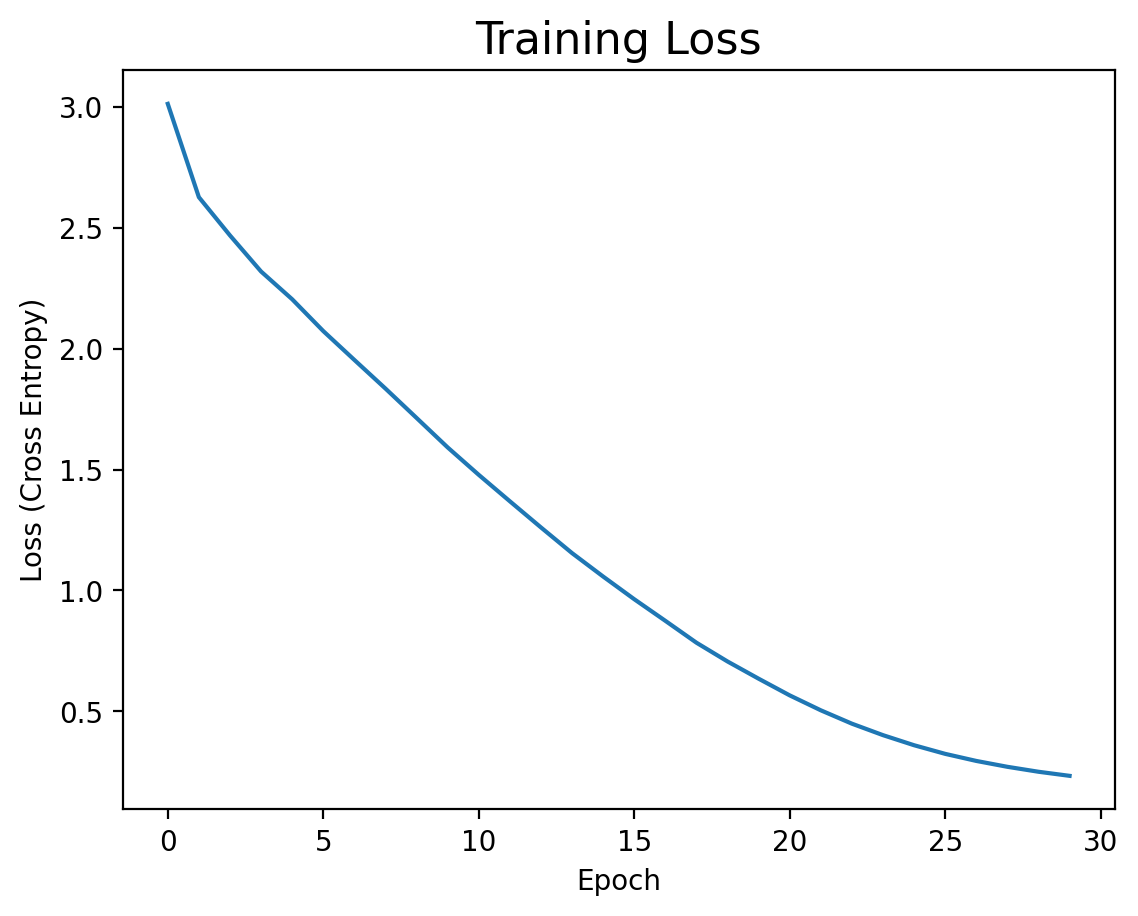

In [618]:
fig = plt.figure()
ax = fig.add_subplot(111)

ax.plot(history["loss"])
ax.set_title("Training Loss", fontsize=16)
ax.set_xlabel("Epoch")
ax.set_ylabel("Loss (Cross Entropy)")

### Your analysis

Please describe your experiments and cut and paste various outputs to show how the model performed at
various numbers of epochs and with various hyperparameters. What characteristics of Java was it able to learn? What did it not learn? The article "The Unreasonable ..." does a nice job of showing this kind of behavior as the number of epochs increases, and you might look at it before writing your answer here.

### Testing different model checkpoints

In [619]:
input_size = len(tok.vocabulary)
model = Model(
    input_size=input_size,
    hidden_size=512,
    num_layers=2,
    dropout=0.0,
    sequence_len=100,
    device=device,
)

In [620]:
# start of training
model.load_state_dict(torch.load("saved_models/epoch_1_val_loss_2.6270687844419105.pth"))

<All keys matched successfully>

In [621]:
text = "System."

print(model.generate(text, tokenizer=tok, max_tokens=20, temperature=1.0))

text = "for (int = 0"
print(model.generate(text, tokenizer=tok, max_tokens=20, temperature=1.0))

text = "if ("
print(model.generate(text, tokenizer=tok, max_tokens=20, temperature=1.0))

System.erdnrtEd(ztis
for (int = 0ci(r,sro
if (
    l,*ehnitezs


In [622]:
# middle of training
model.load_state_dict(
    torch.load("saved_models/epoch_15_val_loss_0.963846954066967.pth")
)

<All keys matched successfully>

In [623]:
text = "System."

print(model.generate(text, tokenizer=tok, max_tokens=20, temperature=1.0))

text = "for (int = 0"
print(model.generate(text, tokenizer=tok, max_tokens=20, temperature=1.0))

text = "if ("
print(model.generate(text, tokenizer=tok, max_tokens=20, temperature=1.0))

System.lufeans);

  
for (int = 0; u;   }
if (int r = 0) {    


In [624]:
# end of training
model.load_state_dict(
    torch.load("saved_models/epoch_29_val_loss_0.2330639288881519.pth")
)

<All keys matched successfully>

In [625]:
text = "System."

print(model.generate(text, tokenizer=tok, max_tokens=20, temperature=1.0))

text = "for (int = 0"
print(model.generate(text, tokenizer=tok, max_tokens=20, temperature=1.0))

text = "if ("
print(model.generate(text, tokenizer=tok, max_tokens=20, temperature=1.0))

System.out.println(t
for (int = 0 in" 2; 
if (t == null)
     


### Analysis

I experimented with different model hyperparameters such as `num_layers` (number of stacked LSTMs), played around with hidden unit sizes: 128, 256, and 512, finding 512 to work the best. In addition, I played around with calculating the gradients by only calculating the gradient of the last character and the gradients of the entire sequence. Calculating the gradients of the entire sequence seemed to yield better performance, however, it is not certain if that result is conclusive. I also experimented with a sequence length of 100 and 128, finding that 100 performs better since the LSTM does not have to worry about long term dependencies. I also played around with the configuration of the fully connected portion of the network, testing two hidden layers and the GELU activation function. These seemed to qualitatively improve the performance, so I kept those additions. From my experimentation, the trained model started to be able to learn the basic syntax of Java like `for`, `if`, and `System.out.println`, but is still very lacking. The model was not able to nail the syntax of the language and seems to have memorized the dataset. It also lacks the ability to write functional code. Furthermore, playing around with the temperature did not yield any more convincing results.

## Problem Two:  Word-Level Generative Model (40 pts)

In this problem you will write another generative model, as you did in HW 03, but this time you will use an LSTM network, GloVe word embeddings, and beam search.

Before you start, read the following blog post to see the core ideas involved in creating a generative model using word embeddings:

https://machinelearningmastery.com/how-to-develop-a-word-level-neural-language-model-in-keras/

You may also wish to consult with chatGPT about how to develop this kind of model in Pytorch.

The requirements for this problem are as follows (they mostly consist of the extensions proposed at
the end of the blog post linked above):

- Develop your code in Pytorch, not Keras
- Use the novel *Persuation* by Jane Austen as your training data (available through the NLTK, you can just grab the sentences using `nltk.corpus.gutenberg.sents('austen-persuasion.txt')`); if you have trouble with RAM you will need to cut down the number of sentences (perhaps by eliminating the longest sentences as well, see next point).
- Develop a sentence-level model by padding sentences to the maximum sentence length in the novel (if this seems extreme, you may wish to delete a small number of the longest sentences to reduce the maximum length). Surround your data sentences with `<s>` and `</s>` and your model should generate one sentence at a time (as you did in HW 03), i.e., it should stop if it generates the `</s>` token.
- Use pretrained GLoVe embeddings with dimension 200, and update them (refine by training further) on the sentences in the novel; if you have trouble with RAM you may use a smaller dimension.
- Experiment with the hyperparameters (sample length, number of layers, uni- or bi-directional, weight_decay, dropout, number of epochs, temperature of the softmax, etc.) as you did in Problem One to find the "sweet spot" where you are generating interesting-looking sentences but not simply repeating sentences from the data. You may want to try adding more linear layers on top to pick the most likely next word.
- Generate sentences using Beam Search, which we describe below.

Your solution should be the code, samples of sentences generated with their score (described below), and your description of the investigation of various hyperparameters, and what strategy ended up seeming to generate the most realistic sentences that were not simply a repeat of sentences in the data.


### Beam Search

Beam search was described, and example shown, in Lecture 14. Here is a brief pseudo-code explaination of what
you need to do:

1. Develop your code as described above so that it can generate single sentences;
2. Copy enough of your code over from HW 03 so that you can calculate the perplexity of
        sentences (using the entire novel, or perhaps even a number of Jane Austen's novels as
        the data source). As an alternative, you may wish to do this separately, store the nested dictionary
        using Pickle, and load it here.
3. Calculate the probability distribution of sentences in your data source that you used in the previous step, similar to what you did at the end of HW 01.
4. Create a "goodness function" which estimates the quality of a sentence as the perplexity times the probability of its length.  This will be applied to all sequences of words, and not just sentences, but as a first approximation this is a way to attempt to make the distribution of sentence lengths similar to that in the novel.
5. Follow the description in slide 7 of Lecture 14 to generate until you have 10 finished sentences. Print these out with their perplexity, probability of their length, and the combined goodness metric.

## Problem Two Solution

In [626]:
import nltk
from nltk.corpus import gutenberg
from tqdm import tqdm
import numpy as np
from typing import List, Tuple, Any
import torch

In [627]:
nltk.download("gutenberg")
nltk.download("punkt")

[nltk_data] Downloading package gutenberg to /home/builds/nltk_data...
[nltk_data]   Package gutenberg is already up-to-date!
[nltk_data] Downloading package punkt to /home/builds/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [628]:
sentences = list(gutenberg.sents("austen-persuasion.txt"))

In [629]:
len(sentences)

3747

In [630]:
SPECIAL_TOKENS = ["[PAD]", "<s>", "</s>"]
EMBEDDING_DIM = 200
BASE_EMBEDDING_SIZE = 400000
PADDING_IDX = 0

In [631]:
def preprocess_sentences(sentences: List[List[str]]) -> List[List[str]]:
    processed_sentences = []
    for sentence in sentences:
        s = ["<s>"]
        for word in sentence:
            s.append(word)
        s.append("</s>")
        processed_sentences.append(s)
    return processed_sentences

In [632]:
processed_sentences = preprocess_sentences(sentences=sentences)
words = [w for s in processed_sentences for w in s]

In [633]:
vocab = {t: idx for idx, t in enumerate(SPECIAL_TOKENS)}
embeddings = []
unique_words = set(words)
new_idx = len(vocab)

with open("GloVe/glove.6B.200d.txt") as f:
  for line in tqdm(f.readlines(), total=BASE_EMBEDDING_SIZE):
    content = line.split()
    word, vector = content[0], content[1:]
    if word in unique_words:
      vocab[word] = new_idx
      new_idx += 1
      vector = np.array(vector, dtype=np.float32)
      embeddings.append(torch.from_numpy(vector))

100%|██████████| 400000/400000 [00:02<00:00, 197652.40it/s]


In [634]:
for word in tqdm(unique_words):
    if word not in vocab:
        vocab[word] = new_idx
        new_idx += 1
        embeddings.append(torch.normal(mean=0, std=1,
                                       size=(EMBEDDING_DIM, ),
                                       dtype=torch.float32))

100%|██████████| 6133/6133 [00:00<00:00, 1609640.60it/s]


In [635]:
embeddings = torch.stack(embeddings, dim=0)

In [636]:
def create_sequences(words: List[str], 
                     input_sequence_len: int) -> List[List[str]]:
    sequences = []
    target_len = input_sequence_len + 1
    for idx in range(0, len(words) - target_len,
                     target_len):
        sequences.append(words[idx: idx + target_len])
    return sequences

In [663]:
class Tokenizer:
    def __init__(
        self, vocabulary: Dict[str, int], dtype: torch.dtype = torch.int64
    ) -> None:
        self.vocabulary = vocabulary
        self.embedding_table = dict(zip(self.vocabulary,
                                        range(len(self.vocabulary))))
        self.reverse_embedding_table = {
            value: key for key, value in self.embedding_table.items()
        }
        self.embedding_dim = len(self.embedding_table)
        self.dtype = dtype

    def encode(self, sequence: List[str]) -> torch.Tensor:
        sequence_ids = torch.tensor([self.embedding_table[s] for s in sequence],
                                    dtype=self.dtype)
        return sequence_ids

    def decode(self, sequence_ids: torch.Tensor) -> List[str]:
        return [self.reverse_embedding_table[s]
                for s in sequence_ids]

In [697]:
class GutenBergDataset(Dataset):
    def __init__(self, vocab_size: int, sequence_ids: torch.Tensor) -> None:
        self.sequence_ids = sequence_ids
        self.input_sequences = self.sequence_ids[:, :-1]
        self.targets = self.sequence_ids[:, -1]
        self.vocab_size = vocab_size
        self.targets = torch.eye(self.vocab_size)[self.targets]
    
    def __len__(self) -> int:
        return len(self.sequence_ids)
    
    def __getitem__(self, index) -> Any:
        input_sequence = self.input_sequences[index]
        target = self.targets[index]
        
        return input_sequence, target

In [698]:
class Model(nn.Module):
    def __init__(
        self,
        sequence_len: int,
        embed_dim: int,
        embeddings: torch.Tensor,
        hidden_size: int,
        num_layers: int,
        dropout: float,
        device: torch.device,
        padding_idx: int = 0,
    ) -> None:
        super().__init__()

        self.sequence_len = sequence_len
        self.embed_dim = embed_dim
        self.num_embeddings = embeddings.size(0)
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.dropout = dropout
        self.device = device
        self.padding_idx = padding_idx
    
        self.embed = nn.Embedding.from_pretrained(embeddings=embeddings,
                                                  padding_idx=self.padding_idx,
                                                  freeze=False)
        
        self.lstm = nn.LSTM(input_size=self.embed_dim,
                            hidden_size=self.hidden_size,
                            num_layers=self.num_layers)
        
        self.fcn = nn.ModuleList(
            [
                nn.Linear(in_features=self.hidden_size, out_features=256),
                nn.GELU(),
                nn.Linear(in_features=256, out_features=self.num_embeddings),
            ]
        )

        self.to(device)
        
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        output = self.embed(x)
        output, (h_n, c_n) = self.lstm(output)
        output = output.contiguous().view(-1, self.hidden_size)
        for layer in self.fcn:
            output = layer(output)
        output = output.view(-1, self.sequence_len, self.num_embeddings)
        return output

In [699]:
# set device
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("GPU is being used.")
else:
    device = torch.device("cpu")
    print("CPU is being used.")

GPU is being used.


In [700]:
model = Model(sequence_len=50,
              embed_dim=EMBEDDING_DIM,
              embeddings=embeddings,
              hidden_size=512,
              num_layers=1,
              dropout=0.0,
              device=device)

In [701]:
BS = 32
tok = Tokenizer(vocabulary=vocab)
sequences = create_sequences(words=words, input_sequence_len=50)
sequence_ids = torch.stack([tok.encode(s) for s in sequences],
                           dim=0)
dataset = GutenBergDataset(vocab_size=len(vocab), sequence_ids=sequence_ids)
dataloader = DataLoader(dataset=dataset, batch_size=BS, shuffle=True, num_workers=6)

In [704]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

def train(
    num_epochs: int,
    save_model_dir: Union[Path, str],
    early_stopping: bool = True,
    patience: int = 3,
) -> Dict[str, List[float]]:
    model.train()

    UPDATE_INTERVAL = 8
    best_epoch_idx = 0
    p = 0

    save_model_dir = Path(save_model_dir)
    if not save_model_dir.exists():
        save_model_dir.mkdir()

    history = dict()
    history["loss"] = []

    for epoch in range(num_epochs):
        with tqdm(total=len(dataloader), unit="batch", desc=f"Epoch {epoch+1}") as pbar:
            N = 0
            running_loss = 0.0

            for idx, (input_sequence, target) in enumerate(dataloader):
                input_sequence, target = (
                    input_sequence.cuda(),
                    target.cuda(),
                )

                optimizer.zero_grad()

                pred_sequence = model(input_sequence)

                loss = loss_fn(pred_sequence, target)
                running_loss += loss.cpu().item() * len(target)
                loss.backward()

                nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

                optimizer.step()

                N += len(target)

                if idx % UPDATE_INTERVAL == 0 or idx == len(dataloader) - 1:
                    pbar.update(min(UPDATE_INTERVAL, len(dataloader) - pbar.n))
                    pbar.set_postfix(loss=loss.cpu().item())

            history["loss"].append(running_loss / N)

            if early_stopping:
                if p == patience:
                    break

                loss = history["loss"][-1]
                if loss < history["loss"][best_epoch_idx]:
                    p = 0
                    best_epoch_idx = epoch
                    torch.save(
                        model.state_dict(),
                        save_model_dir.joinpath(
                            f"epoch_{best_epoch_idx}_val_loss_{loss}.pth"
                        ),
                    )
                else:
                    p += 1

    return history

In [705]:
history = train(num_epochs=1,
                early_stopping=True,
                save_model_dir="saved_models_2",
                patience=3)

Epoch 1:   0%|          | 0/65 [00:00<?, ?batch/s]

: 

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111)

ax.plot(history["loss"])
ax.set_title("Training Loss", fontsize=16)
ax.set_xlabel("Epoch")
ax.set_ylabel("Loss (Cross Entropy)")

### Analysis

Describe what experiments you did with various alternatives as described above, and cut and paste examples illustrating your results.

## Problem Three:  Part-of-Speech Tagging (40 pts)

In this problem, we will experiment with three different approaches to the POS tagging problem, using
the Brown Corpus as our data set.

Before starting this problem, please review Lecture 13 and download the file <a href="https://www.cs.bu.edu/fac/snyder/cs505/Viterbi_Algorithm.ipynb">Viterbi_Algorithm.ipynb</a> from the
class web site.

There are four parts to this problem:

- Part A: You will establish a baseline accuracy for the task.
- Part B: Using the implementation of the Viterbi algorithm for Hidden Markov Models you downloaded, you will determine how much better than the baseline you can do with this very standard method.
- Part C: You will repeat the exercise of Part B, but using an LSTM implementation, exploring several options for the implementation of the LSTM layer.
- Part D: You will evaluate your results, comparing the various methods in the context of the baseline method from Part A.
- Optional: You may wish to try the same task with a transformer such as Bert.


Recall that the Brown Corpus has a list of all sentences tagged with parts of speech. The tags are
a bit odd, and not generally used any more, so we will use a much simpler set of tags the `universal_tagset`.

If you run the following cells, you will see that there are 57,340 sentences, tagged with 12 different tags.


In [ ]:
import numpy as np
import nltk

# The first time you will need to download the corpus:

from nltk.corpus import brown

nltk.download("brown")
nltk.download("universal_tagset")

tagged_sentences = brown.tagged_sents(tagset="universal")

print(
    f"There are {len(tagged_sentences)} sentences tagged with universal POS tags in the Brown Corpus."
)
print("\nHere is the first sentence with universal tags:", tagged_sentences[0])

In [ ]:
# Uncomment to see the complete list of tags.

all_tagged_words = np.concatenate(tagged_sentences)
all_tags = sorted(set([pos for (w, pos) in all_tagged_words]))
print(f"There are {len(all_tags)} universal tags in the Brown Corpus.")
print(all_tags)
print()

### Part A

In this part, you will establish a baseline for the task, using the naive method suggested on slide 35 of Lecture 13:

- Tag every word with its most frequent POS tag (for example, if 'recent' is most frequently tagged as 'ADJ', then assume that every time 'recent' appears in a sentence, it should be tagged with 'ADJ');
- If a word has two or more most frequent tags, choose the one that appears first in the list of sorted tags above.

Note that there will not be any "unknown words."

Use this method to determine your baseline accuracy (it may not be 92% as reported on slide 35!):

- Build a dictionary mapping every word to its most frequent tag;
- Go through the entire tagged corpus, and report the accuracy (percentage of correct tags) of this baseline method.

Do not tokenize or lower-case the words. Use the words and tags exactly as they are in the tagged sentences.

### Part B:  

Now, review the `Viterbi.ipynb` notebook and read through Section 8.4 in Jurafsky & Martin to understand the basic approach that is used in the "Janet will back the bill" example. In detail:

- Cut and paste the code from the Viterby notebook below and run your experiments in this notebook.
- You need to calculate from the Brown Corpus tagged sentences the probabilities for the various matrices used as input to the method:
   - `start_p`: This is the probability that a sentence starts with a given POS (in Figure 8.12 in J & M, this is given as the first line, in the row for `<s>`; simply collect the statistics for the first word in each sentence; it will be of size 1 x 12.
   - `trans_p`: This is the matrix of probabilities that one POS follows another in a sentence; build a 12 x 12 matrix of frequencies for whether the column POS follows the row POS in a sentence and then normalize each row so that it is a probability distribution (each row should add to 1.0)
   - `emit_p`: This is a matrix of size 12 x N, where N is the number of unique words in the corpus, which for each POS (the row) gives the probability that this POS in the output sequence corresponds to a specific word (the column) in the input sequence; again, you should collect frequency statistics about the relationship between POS and words, and normalize so that every row sums to 1.0.
   
Then run the algorithm on all the sentences in the tagged corpus, and determine the accuracy of the Viterbi algorithm. Again, the accuracy is calculated on each word, not on sentences as a whole.

Report your results as a raw accuracy score, and in the two ways that were suggested on slide 12 of Lecture 11: percentage above the baseline established in Part A, and Cohen's Kappa.

In [ ]:
# Viterbi code should be pasted here

### Part C:  

Next, you will need to develop an LSTM model to solve this problem. You may find it useful to
refer to the following, which presents an approach in Keras.

https://www.kaggle.com/code/tanyadayanand/pos-tagging-using-rnn/notebook


You must do the following for this part:

- Develop your code in Pytorch (of course!);
- Use pretrained GloVe embeddings of dimension 200 and update them with the brown sentences; if you run into problems with RAM, you may use a smaller embedding dimension;
- Truncate all sentences to a maximum of length 100 tokens, and pad shorter sentences (as in the reference above);
- Use an LSTM model and try several different choices for the parameters to the layer:
  - `hidden_size`:  Try several different widths for the layer
  - `bidirectional`: Try unidirectional (False) and bidirectional (True)
  - `num_layers`: Try 1 layer and 2 layers
  - `dropout`: In the case of 2 layers, try several different dropouts, including 0.
- Use early stopping with `patience = 50`;  
You do not have to try every possible combination of these parameter choices; a good strategy is to
try them separately, and then try a couple of combinations of the best choices of each.

It is your choice about the other hyperparameters.  

Provide a brief discussion of what you discovered, your best loss and accuracy measures for
validation, and three versions of your testing accuracy, as in Part B.  

### Part D:  

Provide an analysis of what experiments you conducted with hyperparameters, what your results were, and in particular comment on how the two methods compare, especially given that one has *no* choice of hyperparameters, and one has *many* choices of parameters. How useful was the flexibility of choice in hyperparameters in Part C?

#### Optional:

You might want to try doing this problem with a transformer model such as BERT. There are plenty of blog posts out there describing the details, and, as usual, chatGPT would have plenty of things to say about the topic....